# Creating a Training Set for Flooding in Hurricaine Harvey


In [1]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import shapely.geometry
from scipy.misc import imresize
%matplotlib inline

In [1]:
# Tell the script where to look for images. I replaced the actual path with "..." for my own protection.
path_to_harvey_images = ".../Data/Spacenet/Harvey/Post_event/08.31.17/"

# Load the shapefile with the flooding to create grandtruth mask.
flooding = gpd.read_file('Data/Spacenet/Harvey/Vector/DG_flood_Analysis_shapefile1/20170831_130614_Flood_Analysis.shp')

# Convert the CRS (coordinate system) of the flooding file
flooding.to_crs({'init': 'epsg:4326'}, inplace=True)

# Get a list of all of the tif files
tif_files = [os.path.join(path_to_harvey_images, fn) 
             for fn in os.listdir(path_to_harvey_images) 
             if (fn.endswith('tif') or fn.endswith('tif.1'))]

# Get the shape of each image
geometry = []
for tif_file in tif_files:
    with rasterio.open(tif_file) as src:
        geometry.append(shapely.geometry.box(*src.bounds))

# Create a GeoDataFrame with the image footprints
footprints = gpd.GeoDataFrame({'file_name': tif_files}, geometry=geometry, crs={'init': 'epsg:4326'})

# Filter for just the images that have flooding in them 
footprints_with_flooding = footprints[footprints.index.isin(
                            gpd.sjoin(flooding, footprints, how='inner', op='intersects').index_right.unique()
                            )]


In [2]:
def tile_image(file_name, tile_size):
    "Striding through the coordinate and extracting metadata"
    src = rasterio.open(file_name)
    
    width = src.width
    height = src.height
    
    for i in range(0, width - tile_size, tile_size):
        for j in range(0, height - tile_size, tile_size):
            window = ((j, j + tile_size), (i, i + tile_size))
            
            # Load the tile
            img = src.read(window=window).transpose([1,2,0])
            
            # Get metadata about the tile
            transform = list(np.array(~src.window_transform(window))[[0, 1, 3, 4, 2, 5]])
            box = shapely.geometry.box(*src.window_bounds(window))
            
            # Skip any image with more than 10% missing pixels
            if (img == 0).all(axis=2).sum() / img.size > 0.1:
                continue
            
            yield img, transform, box           

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV"""
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def get_mask(mask_poly, img_shape, transform):
    "Creating mask"
    # Transform the poly into image coords
    mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, transform)
    
    # Add a buffer to pad it out a little
    mask_poly_pxcoords = mask_poly_pxcoords.buffer(1)
    
    return make_mask(img_shape, mask_poly_pxcoords)

def resize(img, new_shape):
    "Resizing image"
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized

In [5]:
def make_training_set(range_list):
    "Function for creating the data set"
    #Setting starting count for file names based on which CPU processor is used to avoid overlap.
    #The counting is for the names of the image tiles.
    tile_no = range_list[2] * ((range_list[1]-range_list[0])*100) + 1000
    
    #Going through a subset of the image tiles
    for path in footprints_with_flooding.file_name[range_list[0]:range_list[1]]:
        for tile_img, tile_transform, tile_box in tile_image(path, 1000):
            #Intersecting the mask and image coordinates
            mask_poly = flooding[flooding.intersects(tile_box)].intersection(tile_box).unary_union

            # Skip tiles with no flooding
            if mask_poly.area < 1e-12:
                continue
            
            #Iterate each tile and count how many total black pixels (zeros) there are  
            count = 0
            for pixel in tile_img:
                for rgb in pixel:
                    if rgb.sum() == 0:
                        count += 1
            if count <= 50:
                mask = get_mask(mask_poly, tile_img.shape[:2], tile_transform)
                
                #Exporting the data
                np.save("training_tiles_1000size/%d_mask"%tile_no, mask)
                np.save("training_tiles_1000size/%d_img"%tile_no, tile_img)
                tile_no += 1


## Multiprocessing data generation

In [6]:
#Generate tiles using multiprocessing 
from multiprocessing import Pool

#Creating a folder for the image tiles
if not os.path.exists('training_tiles_1000size'):
    os.makedirs('training_tiles_1000size')

#Partition the images to 8 sets for 8 cores
parts = footprints_with_flooding.shape[0]/8

#The first two elements tell each processor which images to process. The third element is for the starting file name.
range_list = [[0,parts,0], [parts,parts*2,1], [parts*2,parts*3,2], [parts*3,parts*4,3],
              [parts*4,parts*5,4], [parts*5,parts*6,5], [parts*6,parts*7,7], [parts*7,footprints_with_flooding.shape[0]-1,8]]

#I have 8 virutal cores.
pool = Pool(processes=8)

#Starting the processes
results = pool.map(make_training_set, range_list)

#Closing the processes
pool.close()
pool.join()

## Visualizing the image and mask 

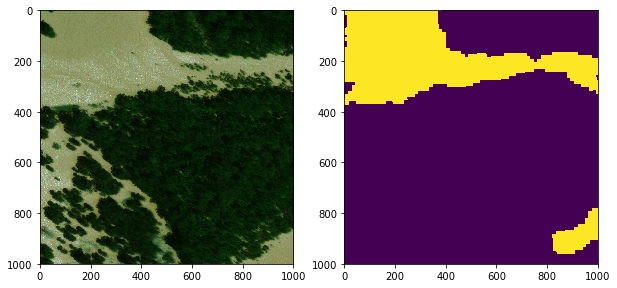

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

tile_no = 2000
img = np.load('training_tiles_1000size/%d_img.npy'%tile_no)
mask = np.load('training_tiles_1000size/%d_mask.npy'%tile_no)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(img)
ax2.imshow(mask)

